# Load Datasets

In [49]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
import os

def get_data_path(slug_name):
    base1 = f"/kaggle/input/{slug_name}"
    base2 = "/kaggle/input"
    if os.path.exists(base1):
        return base1
    elif os.path.exists(base2):
        return base2
    else:
        return "./Data"

data_dir = get_data_path("international-hotel-booking-analytics")

users = pd.read_csv(f"{data_dir}/users.csv")
hotels = pd.read_csv(f"{data_dir}/hotels.csv")
reviews = pd.read_csv(f"{data_dir}/reviews.csv")

# Data Cleaning

In [53]:
def clean_data(hotels, reviews, users):
    """
    Clean and merge datasets before model training.
    Focuses only on data consistency and structure.
    """
    
    # --- Clean Users ---
    users_clean = users.copy()
    age_mapping = {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55+': 4}
    users_clean['age_group'] = users_clean['age_group'].map(age_mapping)

    # --- Clean Reviews ---
    reviews_clean = reviews.copy()
    reviews_clean['review_date'] = pd.to_datetime(reviews_clean['review_date'])

    # --- Clean Hotels ---
    hotels_clean = hotels.copy()

    # --- Merge ---
    df = pd.merge(reviews_clean, users_clean, on='user_id', how='inner')
    df = pd.merge(df, hotels_clean, on='hotel_id', how='inner')

    df.rename(columns={'country_x': 'hotel_country', 'country_y': 'user_country'}, inplace=True)

    # --- Map countries to regions ---
    country_to_group = {
        'United States': 'North_America', 'Canada': 'North_America',
        'Germany': 'Western_Europe', 'France': 'Western_Europe',
        'United Kingdom': 'Western_Europe', 'Netherlands': 'Western_Europe',
        'Spain': 'Western_Europe', 'Italy': 'Western_Europe',
        'Russia': 'Eastern_Europe', 'China': 'East_Asia', 'Japan': 'East_Asia',
        'South Korea': 'East_Asia', 'Thailand': 'Southeast_Asia', 'Singapore': 'Southeast_Asia',
        'United Arab Emirates': 'Middle_East', 'Turkey': 'Middle_East',
        'Egypt': 'Africa', 'Nigeria': 'Africa', 'South Africa': 'Africa',
        'Australia': 'Oceania', 'New Zealand': 'Oceania',
        'Brazil': 'South_America', 'Argentina': 'South_America',
        'India': 'South_Asia', 'Mexico': 'North_America_Mexico'
    }
    df['country_group'] = df['user_country'].map(country_to_group).fillna('Other')

    # --- Final cleanup ---
    df = df.drop_duplicates()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    text_cols = df.select_dtypes(include=['object']).columns
    df[text_cols] = df[text_cols].fillna('Unknown')

    cols_to_drop = [
        'user_id', 'hotel_id', 'review_id', 'join_date',
        'lat', 'lon', 'user_country', 'hotel_name',
        'review_text', 'review_date'
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    return df
df = clean_data(hotels, reviews, users)

In [55]:
def prepare_for_model_training(df):
    """
    Prepare dataframe for model training using one-hot encoding.
    Handles categorical encoding and feature removal.
    """
    
    # Copy to keep original clean
    df_model = df.copy()
    
    # Drop hotel_country to avoid leakage
    if 'hotel_country' in df_model.columns:
        df_model = df_model.drop(columns=['hotel_country'])
    
    # Encode gender
    if 'user_gender' in df_model.columns:
        df_model = pd.get_dummies(df_model, columns=['user_gender'], drop_first=True, dtype=int)
    
    # Encode traveller type
    if 'traveller_type' in df_model.columns:
        df_model = pd.get_dummies(df_model, columns=['traveller_type'], drop_first=True, dtype=int)
    
    return df_model

In [56]:
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
df.head()

Dataset shape: (50000, 20)

Columns: ['score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'user_gender', 'hotel_country', 'age_group', 'traveller_type', 'city', 'star_rating', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'country_group']

Sample data:


,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,user_gender,hotel_country,age_group,traveller_type,city,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,country_group
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Female,New Zealand,1,Solo,New York,5,9.1,8.8,8.9,9.5,8.6,8.0,North_America
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Female,United Kingdom,2,Couple,Tokyo,5,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Female,Spain,4,Couple,Cairo,5,8.8,8.7,8.6,9.1,8.7,8.4,Africa
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Female,United Kingdom,2,Business,Barcelona,5,9.2,9.1,8.9,9.7,9.0,8.8,Western_Europe
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Male,Australia,3,Family,Moscow,5,9.1,9.3,9.0,9.0,9.1,8.6,Eastern_Europe


In [57]:
print("\nSummary statistics for numeric columns:")
display(df.describe())


Summary statistics for numeric columns:


,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,age_group,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,8.943460,9.052558,9.024404,8.743062,9.176410,8.972076,8.434540,1.812920,5.0,9.091592,9.063918,8.917196,9.270406,9.015730,8.513232
std,0.180878,0.504296,0.423927,0.498320,0.421086,0.397775,0.529321,1.131418,0.0,0.226334,0.234129,0.286064,0.347649,0.236695,0.258259
min,8.200000,7.700000,7.900000,7.600000,7.900000,7.900000,6.800000,0.000000,5.0,8.700000,8.600000,8.500000,8.500000,8.600000,7.900000
25%,8.800000,8.700000,8.700000,8.400000,8.900000,8.700000,8.100000,1.000000,5.0,8.900000,8.900000,8.700000,9.000000,8.800000,8.400000
50%,8.900000,9.100000,9.000000,8.700000,9.200000,9.000000,8.500000,2.000000,5.0,9.100000,9.100000,8.900000,9.300000,9.000000,8.500000
75%,9.100000,9.400000,9.300000,9.100000,9.500000,9.200000,8.800000,3.000000,5.0,9.300000,9.200000,9.100000,9.600000,9.200000,8.700000
max,9.600000,10.000000,10.000000,10.000000,10.000000,10.000000,9.700000,4.000000,5.0,9.600000,9.500000,9.600000,9.800000,9.500000,8.900000


In [65]:
print("\nValue counts for categorical columns:")
categorical_cols = ['age_group', 'traveller_type', 'user_gender', 'city', 'hotel_country', 'country_group']
for col in categorical_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts())


Value counts for categorical columns:

age_group distribution:
age_group
1    16322
2    15452
3     7824
0     5415
4     4987
Name: count, dtype: int64

traveller_type distribution:
traveller_type
Couple      17240
Family      11945
Solo        10444
Business    10371
Name: count, dtype: int64

user_gender distribution:
user_gender
Male      23630
Female    21659
Other      4711
Name: count, dtype: int64

city distribution:
city
Cairo             2104
Seoul             2071
Wellington        2060
Bangkok           2055
Lagos             2049
Shanghai          2040
Barcelona         2039
Dubai             2035
Berlin            2022
Singapore         2015
Mexico City       2004
New York          1998
Paris             1993
Mumbai            1989
Cape Town         1979
Rome              1971
Tokyo             1971
Moscow            1970
Toronto           1964
Rio de Janeiro    1962
Buenos Aires      1956
Sydney            1954
Amsterdam         1949
Istanbul          1948
London      

In [68]:
users

,user_id,user_gender,country,age_group,traveller_type,join_date
0,1,Female,United Kingdom,35-44,Solo,2024-09-29
1,2,Male,United Kingdom,25-34,Solo,2023-11-29
2,3,Female,Mexico,25-34,Family,2022-04-03
3,4,Male,India,35-44,Family,2023-12-02
4,5,Other,Japan,25-34,Solo,2021-12-18
...,...,...,...,...,...,...
1995,1996,Male,Netherlands,45-54,Couple,2020-09-06
1996,1997,Female,South Korea,18-24,Couple,2023-05-24
1997,1998,Male,China,45-54,Solo,2022-12-09
1998,1999,Female,China,55+,Business,2024-12-27


In [67]:
hotels

,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.75800,-73.985500,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.50720,-0.127600,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.85660,2.352200,8.8,9.4,8.7,9.6,9.3,8.1
3,4,Kyo-to Grand,Tokyo,Japan,5,35.68950,139.691700,9.6,9.0,9.3,8.5,9.5,8.2
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.27690,55.296200,9.3,9.5,9.6,8.9,9.4,8.5
5,6,Marina Bay Zenith,Singapore,Singapore,5,1.29027,103.851959,9.2,9.1,9.4,9.7,9.1,8.3
6,7,Sydney Harbour Grand,Sydney,Australia,5,-33.86510,151.209900,8.9,9.0,8.5,9.8,8.9,8.4
7,8,Copacabana Lux,Rio de Janeiro,Brazil,5,-22.90680,-43.172900,9.0,8.7,8.6,9.5,8.8,8.6
8,9,Berlin Mitte Elite,Berlin,Germany,5,52.52000,13.405000,9.3,9.2,9.0,9.1,9.1,8.7
9,10,The Maple Grove,Toronto,Canada,5,43.65320,-79.383200,9.4,9.3,9.2,8.8,9.2,8.8


In [69]:
reviews

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Friend million student social study yeah. Grow...
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Huge girl already remain truth behind card. Ap...
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Cover feeling call community serve television ...
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,1786,24,2022-08-07,8.4,8.2,8.2,8.5,9.1,8.3,7.5,Thing her against garden method magazine. Inte...
49996,49997,1739,8,2025-03-05,8.8,8.8,9.0,8.0,9.5,8.8,8.7,But benefit away major. Story kid often offici...
49997,49998,1566,6,2025-05-03,9.1,9.8,9.1,8.5,9.6,9.3,8.0,But certainly part special moment certain buil...
49998,49999,10,21,2024-09-27,9.0,8.7,9.1,8.7,9.7,9.0,8.7,Ask suffer space return. Hospital material the...


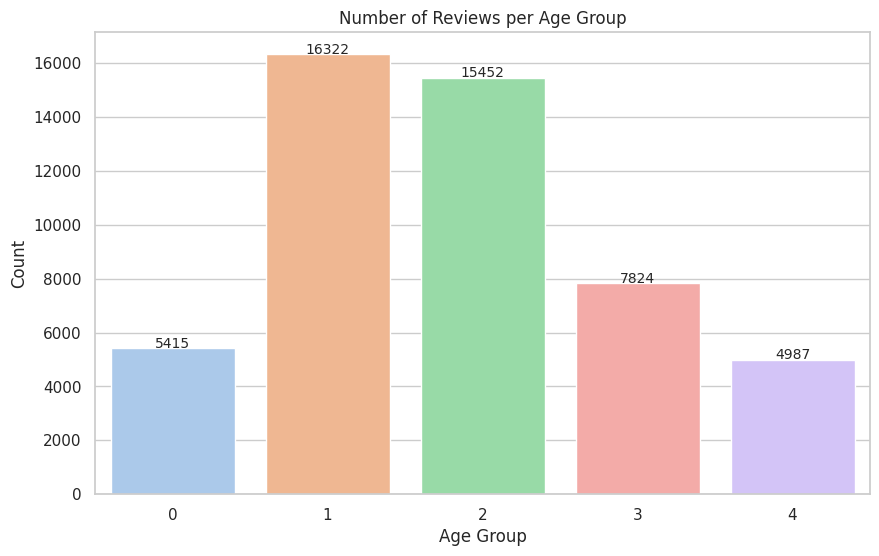

In [70]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='age_group', palette='pastel')
plt.title('Number of Reviews per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Add counts above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 20,  # adjust +20 for spacing
            f'{int(height)}', ha="center", fontsize=10)

plt.show()

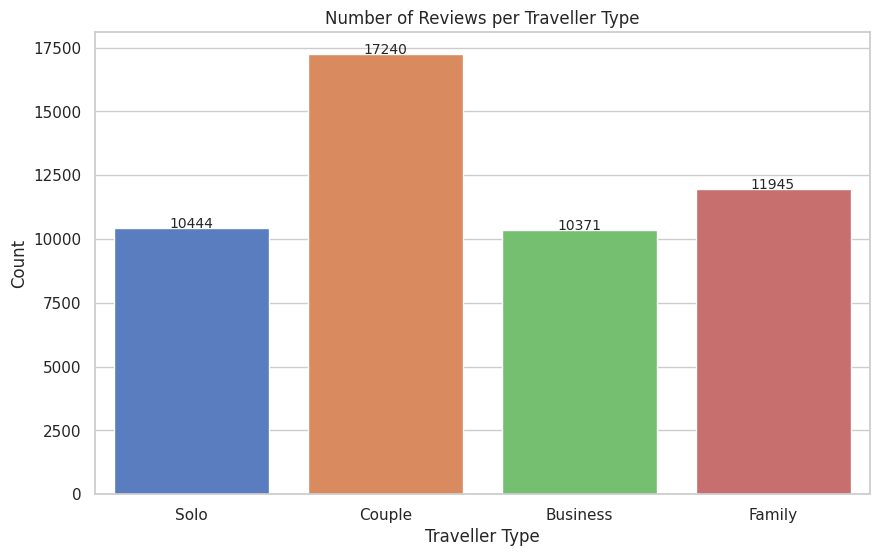

In [71]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='traveller_type', palette='muted')
plt.title('Number of Reviews per Traveller Type')
plt.xlabel('Traveller Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, str(int(p.get_height())), 
            ha='center', fontsize=10)
plt.show()

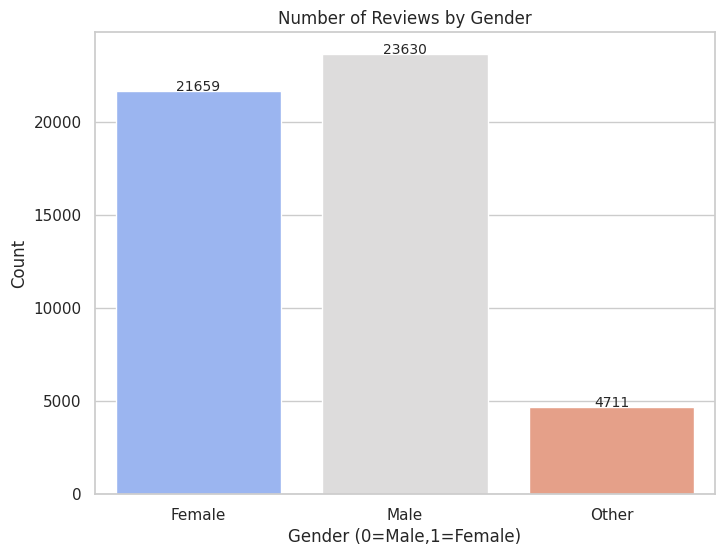

In [72]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='user_gender', palette='coolwarm')
plt.title('Number of Reviews by Gender')
plt.xlabel('Gender (0=Male,1=Female)')
plt.ylabel('Count')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, str(int(p.get_height())), 
            ha='center', fontsize=10)
plt.show()

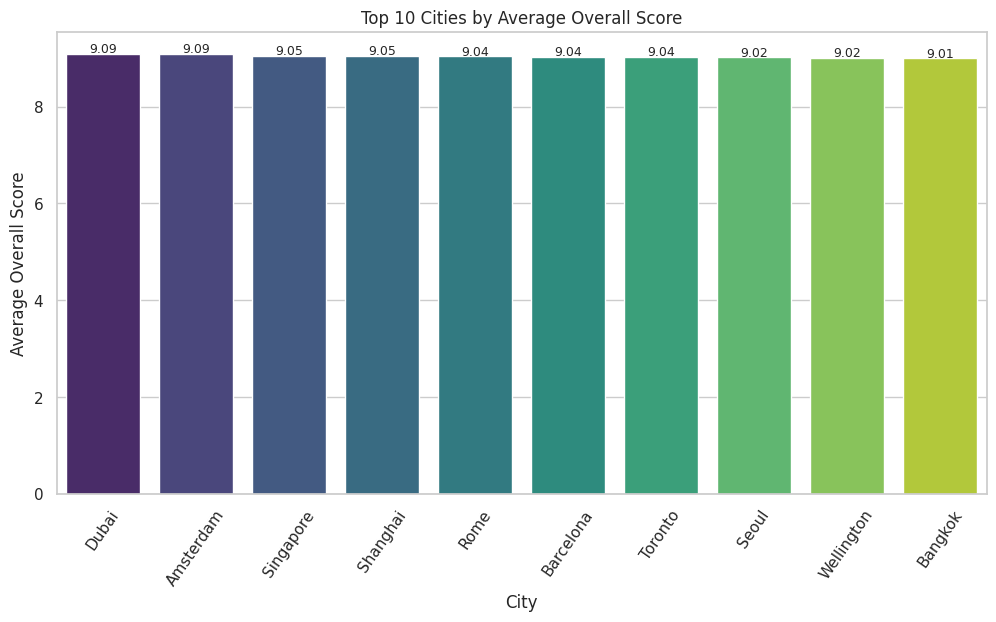

In [75]:
top_cities = df.groupby('city')['score_overall'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_cities, x='city', y='score_overall', palette='viridis')
plt.xticks(rotation=55)
plt.title('Top 10 Cities by Average Overall Score')
plt.xlabel('City')
plt.ylabel('Average Overall Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.02, f'{p.get_height():.2f}', 
            ha='center', fontsize=9)
plt.show()

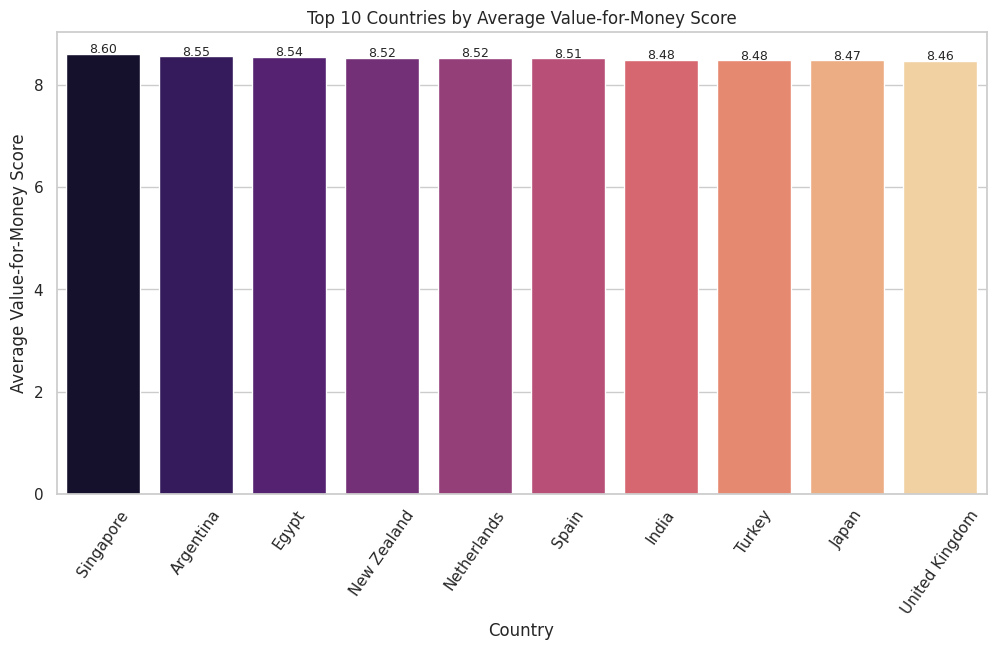

In [74]:
top_countries = df.groupby('hotel_country')['score_value_for_money'].mean().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_countries, x='hotel_country', y='score_value_for_money', palette='magma')
plt.xticks(rotation=55)
plt.title('Top 10 Countries by Average Value-for-Money Score')
plt.xlabel('Country')
plt.ylabel('Average Value-for-Money Score')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.02, f'{p.get_height():.2f}', 
            ha='center', fontsize=9)
plt.show()

## Histogram Analysis
Histograms show the distribution of numerical variables, helping us understand the shape, skewness, center, and spread of data.

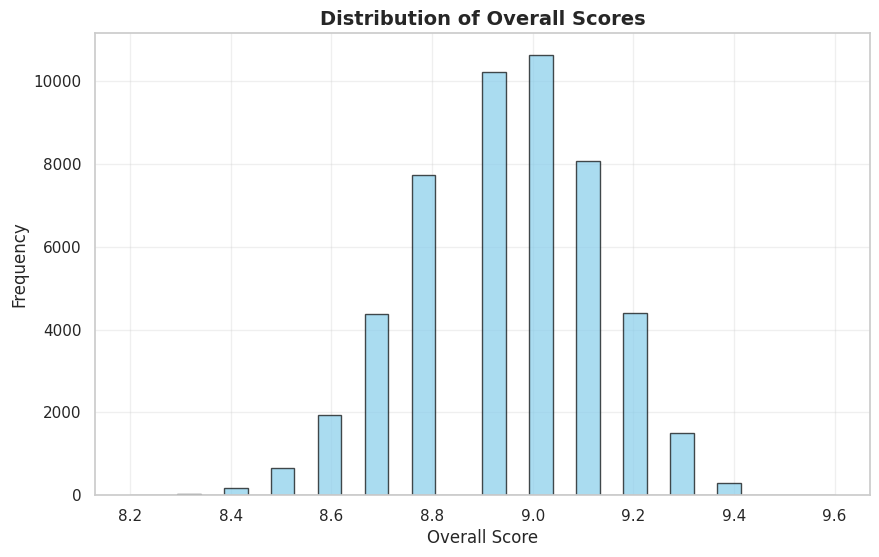

Mean Overall Score: 8.94
Standard Deviation: 0.18
Skewness: -0.16


In [77]:
# Histogram of Overall Scores
plt.figure(figsize=(10, 6))
plt.hist(df['score_overall'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Overall Scores', fontsize=14, fontweight='bold')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean Overall Score: {df['score_overall'].mean():.2f}")
print(f"Standard Deviation: {df['score_overall'].std():.2f}")
print(f"Skewness: {df['score_overall'].skew():.2f}")

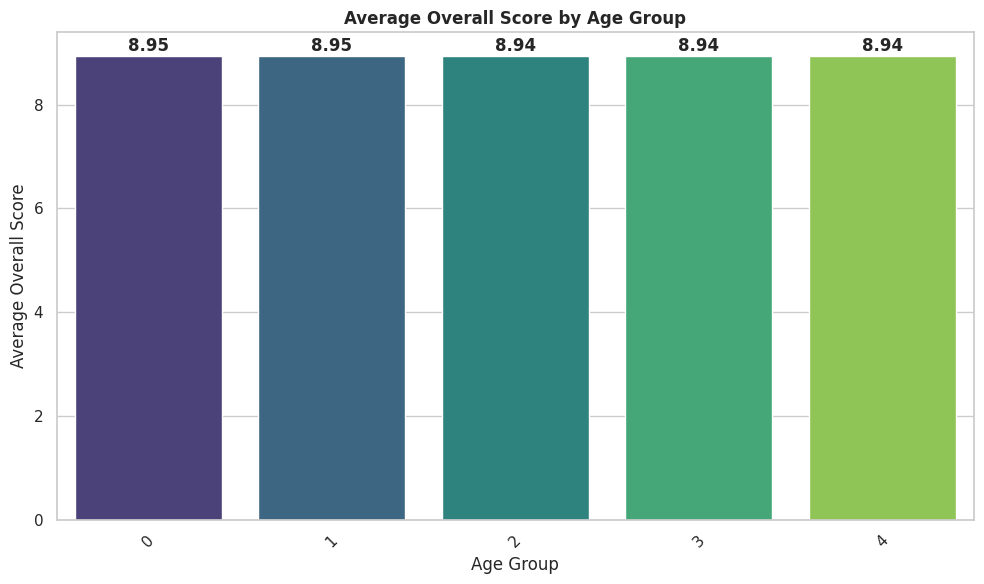

Age Group Score Analysis:
• 0.0: 8.95 average score
• 1.0: 8.95 average score
• 2.0: 8.94 average score
• 3.0: 8.94 average score
• 4.0: 8.94 average score


In [78]:
# Bar Plot: Average Overall Score by Age Group (using Seaborn)
plt.figure(figsize=(10, 6))

# Create age groups aggregation - using original columns before one-hot encoding
age_score_data = df.groupby('age_group')['score_overall'].mean().reset_index()

sns.barplot(data=age_score_data, x='age_group', y='score_overall', palette='viridis')
plt.title('Average Overall Score by Age Group', fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Average Overall Score')
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(age_score_data['score_overall']):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Age Group Score Analysis:")
for idx, row in age_score_data.iterrows():
    print(f"• {row['age_group']}: {row['score_overall']:.2f} average score")

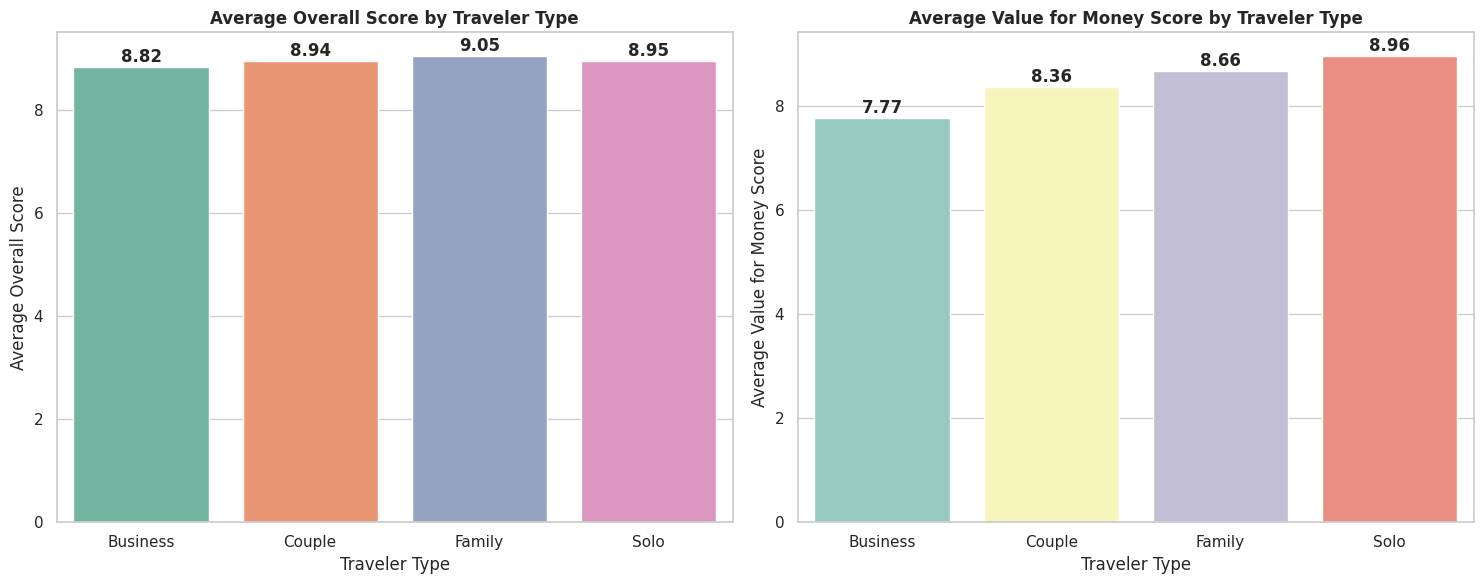

Traveler Type Comparison:
Overall Scores:
• Business: 8.82
• Couple: 8.94
• Family: 9.05
• Solo: 8.95

Value for Money Scores:
• Business: 7.77
• Couple: 8.36
• Family: 8.66
• Solo: 8.96


In [79]:
# Bar Plot: Average Scores by Traveler Type (Comparison)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Overall Score by Traveler Type  
traveler_overall = df.groupby('traveller_type')['score_overall'].mean().reset_index()
sns.barplot(data=traveler_overall, x='traveller_type', y='score_overall', 
           palette='Set2', ax=axes[0])
axes[0].set_title('Average Overall Score by Traveler Type', fontweight='bold')
axes[0].set_xlabel('Traveler Type')
axes[0].set_ylabel('Average Overall Score')

# Add value labels
for i, v in enumerate(traveler_overall['score_overall']):
    axes[0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Right plot: Value for Money Score by Traveler Type
traveler_value = df.groupby('traveller_type')['score_value_for_money'].mean().reset_index()
sns.barplot(data=traveler_value, x='traveller_type', y='score_value_for_money', 
           palette='Set3', ax=axes[1])
axes[1].set_title('Average Value for Money Score by Traveler Type', fontweight='bold')
axes[1].set_xlabel('Traveler Type')
axes[1].set_ylabel('Average Value for Money Score')

# Add value labels
for i, v in enumerate(traveler_value['score_value_for_money']):
    axes[1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Traveler Type Comparison:")
print("Overall Scores:")
for idx, row in traveler_overall.iterrows():
    print(f"• {row['traveller_type']}: {row['score_overall']:.2f}")
print("\nValue for Money Scores:")  
for idx, row in traveler_value.iterrows():
    print(f"• {row['traveller_type']}: {row['score_value_for_money']:.2f}")

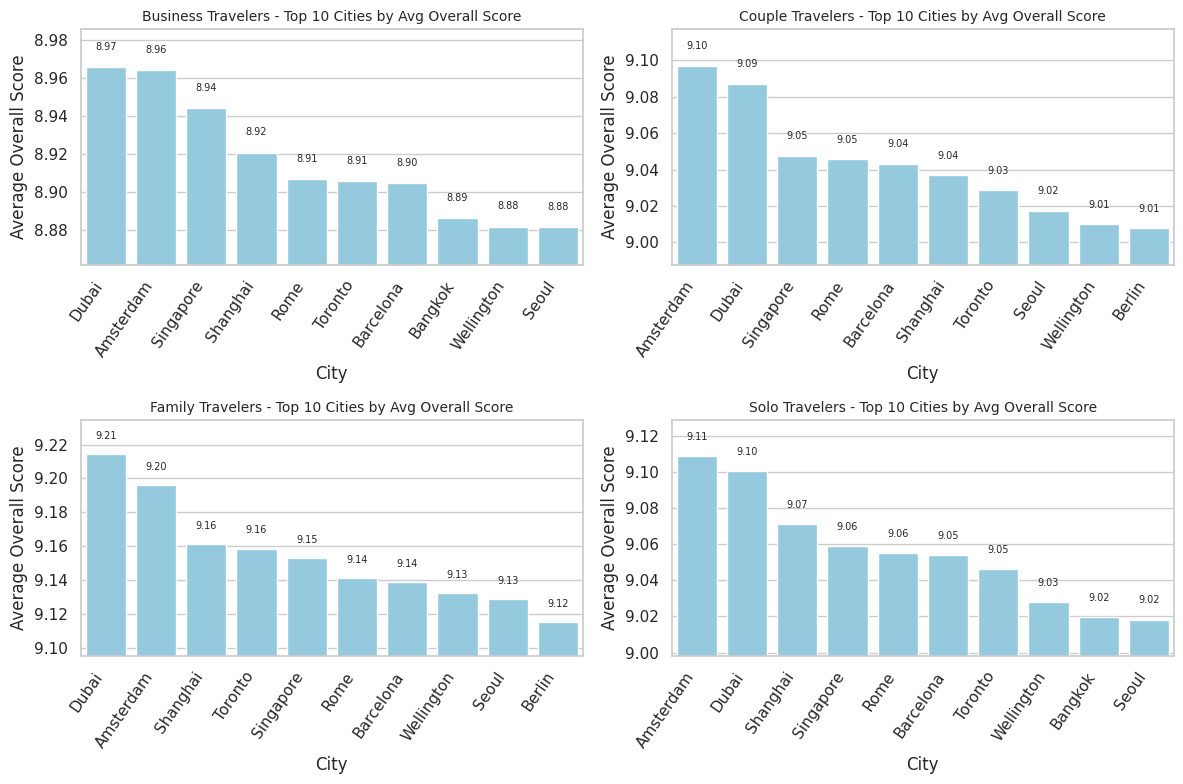

In [80]:
grouped1_df = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index()
n = 10
top_n_cities = (
    grouped1_df
    .sort_values(['traveller_type', 'score_overall'], ascending=[True, False])
    .groupby('traveller_type')
    .head(n)
)
top_n_cities.head(20)
plt.figure(figsize=(12, 8))
traveller_types = top_n_cities['traveller_type'].unique()

for i, ttype in enumerate(traveller_types):
    plt.subplot(2, 2, i + 1)
    subset = (
        top_n_cities[top_n_cities['traveller_type'] == ttype]
        .sort_values('score_overall', ascending=False)
    )
    
    # Plot vertical bar chart for each traveller type
    sns.barplot(data=subset, x='city', y='score_overall', color='skyblue')
    
    # Annotate each bar with its value
    for index, value in enumerate(subset['score_overall']):
        plt.text(index, value + 0.009, f'{value:.2f}', ha='center', fontsize=7)
    
    # Title and axis labels
    plt.title(f'{ttype} Travelers - Top {n} Cities by Avg Overall Score', fontsize=10)
    plt.xlabel('City')
    plt.ylabel('Average Overall Score')
    plt.ylim(subset['score_overall'].min() - 0.02, subset['score_overall'].max() + 0.02)
    plt.xticks(rotation=55, ha='right')

plt.tight_layout()
plt.show()

### Based on the average overall scores from traveler reviews, the best city for each traveler type is:

- **Business Travelers:** **Dubai** (Average Score: 8.97)
- **Couple Travelers:** **Amsterdam** (Average Score: 9.10)
- **Family Travelers:** **Dubai** (Average Score: 9.21)
- **Solo Travelers:** **Amsterdam** (Average Score: 9.11)

These recommendations are based on the top-rated cities according to user reviews for each traveler category.

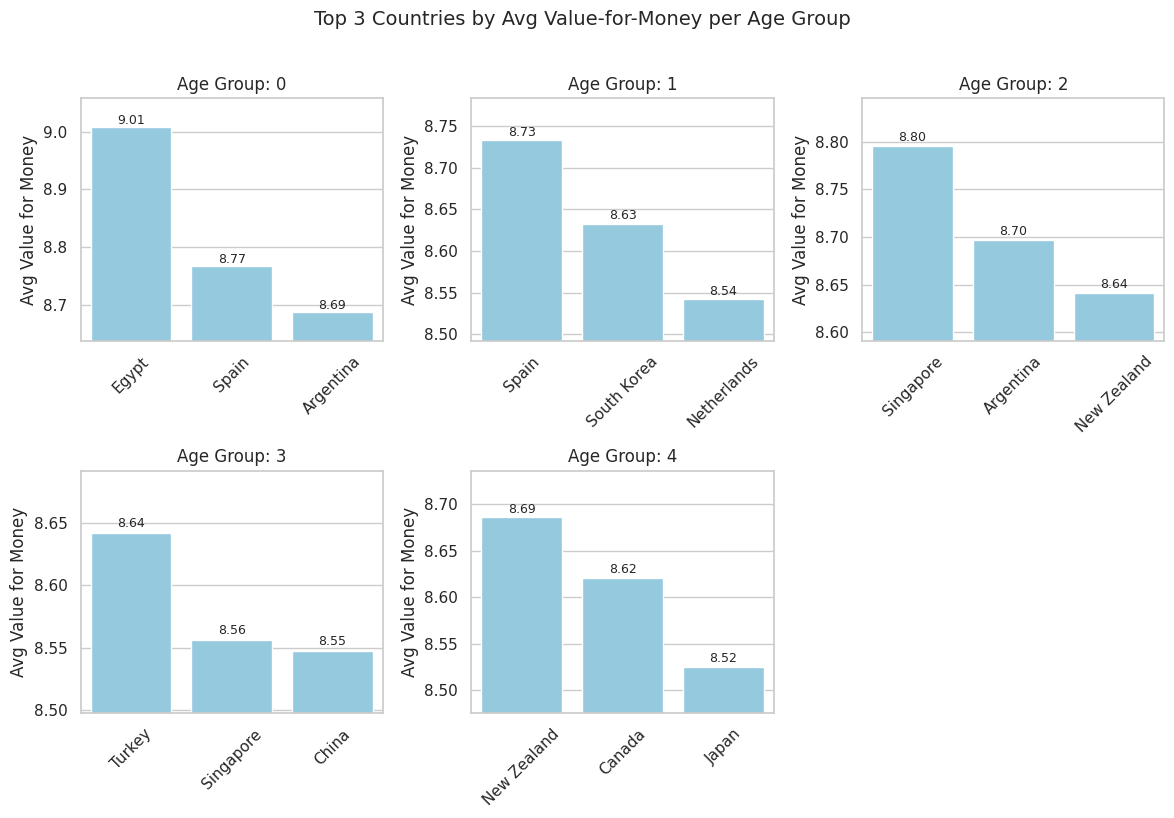

In [81]:
# Group by age_group and hotel_country to get mean value_for_money score
x = 3
grouped_age = (
    df.groupby(['age_group', 'hotel_country'])['score_value_for_money']
      .mean()
      .reset_index()
      .sort_values(['age_group', 'score_value_for_money'], ascending=[True, False])
      .groupby('age_group')
      .head(x)
      .reset_index(drop=True)
)

# Plot top 3 countries per age group
plt.figure(figsize=(12, 8))
age_groups = grouped_age['age_group'].unique()

ncols = 3
nrows = (len(age_groups) + ncols - 1) // ncols

for i, ag in enumerate(age_groups):
    ax = plt.subplot(nrows, ncols, i + 1)
    subset = grouped_age[grouped_age['age_group'] == ag].sort_values('score_value_for_money', ascending=False)
    sns.barplot(data=subset, x='hotel_country', y='score_value_for_money', ax=ax, color='skyblue')
    for idx, val in enumerate(subset['score_value_for_money']):
        ax.text(idx, val + 0.005, f'{val:.2f}', ha='center', fontsize=9)
    ax.set_title(f'Age Group: {ag}')
    ax.set_xlabel('')
    ax.set_ylabel('Avg Value for Money')
    ax.set_ylim(subset['score_value_for_money'].min() - 0.05, subset['score_value_for_money'].max() + 0.05)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Top 3 Countries by Avg Value-for-Money per Age Group', fontsize=14, y=1.02)
plt.show()

### Top 3 Countries by Avg Value-for-Money per Traveler Age Group

- **Age Group 18-24:**  
  1. Egypt – 9.01  
  2. Spain – 8.77 
  3. Argentina – 8.69  

- **Age Group 25-34:**  
  1. Spain – 8.73  
  2. South Korea – 8.63  
  3. Netherlands – 8.54

- **Age Group 35-44:**  
  1. Singapore – 8.80  
  2. Argentina – 8.70  
  3. New Zealand – 8.64  

- **Age Group 45-54:**  
  1. Turkey – 8.64  
  2. Singapore – 8.56  
  3. China – 8.55  

- **Age Group 55+:**  
  1. New Zealand  – 8.69  
  2. Canada – 8.62  
  3. Japan – 8.52

invalid value encountered in less


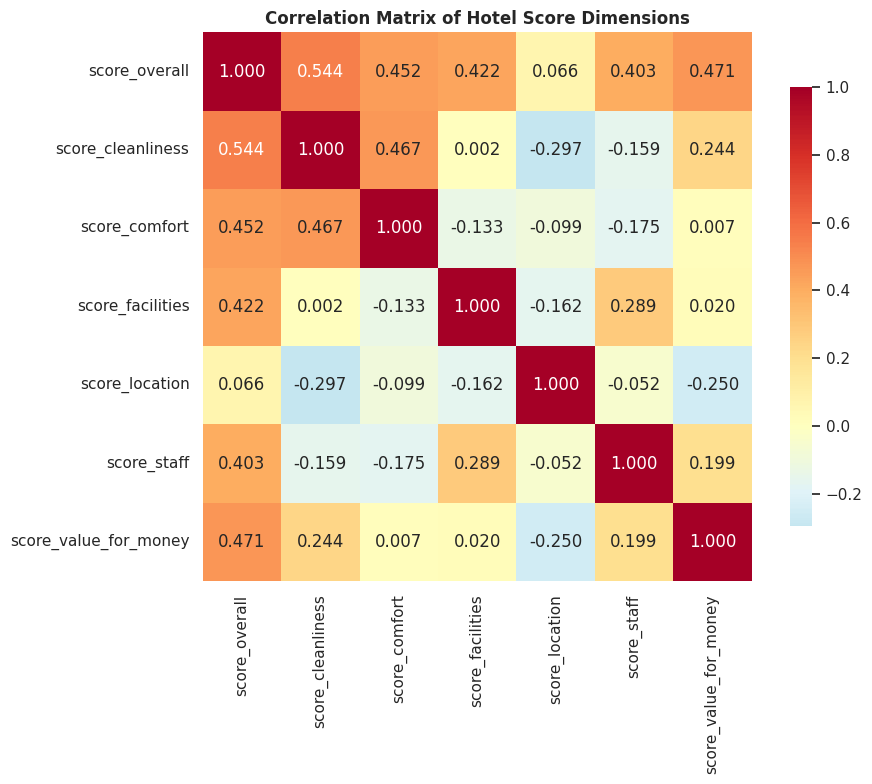

Correlation Heatmap Analysis:
• Values range from -1 to 1
• Red colors indicate strong positive correlation
• Blue colors indicate strong negative correlation
• White/neutral colors indicate weak correlation


In [82]:
# Correlation Heatmap of Key Score Features
plt.figure(figsize=(10, 8))

# Select key score columns for correlation analysis
score_columns = ['score_overall', 'score_cleanliness', 'score_comfort', 
                'score_facilities', 'score_location', 'score_staff', 'score_value_for_money']

correlation_matrix = df[score_columns].corr()

# Create correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
           square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Hotel Score Dimensions', fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation Heatmap Analysis:")
print("• Values range from -1 to 1")
print("• Red colors indicate strong positive correlation")  
print("• Blue colors indicate strong negative correlation")
print("• White/neutral colors indicate weak correlation")

# Predictive Modeling Task

## Model Development Process

Before jumping into model training, we first performed **Exploratory Data Analysis (EDA)** to understand how different variables relate to each other.  
This included generating **correlation heatmaps** to visualize the relationships between hotel review scores and identifying which features might contribute most to prediction accuracy.

---

### 🔹 Step 1 — Initial Experiments

We started with a **simple baseline model** that included only a few basic hotel and user attributes.  
This initial setup was mainly used to test the modeling pipeline and identify potential issues such as **underfitting** or poor feature representation.  

As expected, the model achieved **inconsistent precision** between training and validation sets, suggesting that more contextual information was needed.

---

### 🔹 Step 2 — Feature Expansion

Next, we **expanded the feature set** by including additional review-based scores and user demographic attributes (like *traveler type* and *age group*).  
This step significantly improved the model’s **performance and stability**, as it allowed the neural network to capture more complex relationships across different traveler profiles and hotel characteristics.

---

### 🔹 Step 3 — Correlation and Feature Understanding

To better understand how features interacted, we revisited the **correlation analysis results** and used them to refine our final input set.  
The correlation study helped **eliminate redundant variables** and ensured that the model relied on **informative features** rather than overlapping ones.

---

### 🔹 Step 4 — Model Interpretability with SHAP

After achieving a stable model, we used **SHAP (SHapley Additive Explanations)** to interpret the model’s predictions.  
The SHAP analysis revealed the **relative importance** of each feature — for example, how much *score_location* or *star_rating* contributed to the predicted traveler group.  

This interpretability step confirmed that the model’s decisions aligned with **logical and data-driven patterns** rather than random correlations.


Data Pre-processing and Feature Engineering
Understanding the step
Need for the step
Effect on the step on the data distribution, range, values, etc

# Data Pre-processing and Feature Engineering

## Data Pre-processing
- **Purpose:** Clean and prepare raw data for modeling.  
- **Steps:** Map `age_group` to numbers, fill missing values, drop irrelevant columns.  
- **Effect:** Ensures consistent, complete, and usable data.

## Feature Engineering
- **Purpose:** Transform data for the model.  
- **Steps:** One-hot encode `user_gender` and `traveller_type`, map countries to regions.  
- **Effect:** Converts categorical text to numeric, adds useful features.

## Example: Before & After

**Before:**  
| user_gender | traveller_type | age_group | cleanliness |
|-------------|----------------|-----------|------------|
| Male        | Solo           | 25-34     | 9          |
| Female      | Family         | 35-44     | NaN        |

**After:**  
| age_group | cleanliness | user_gender_Male | traveller_type_Solo | traveller_type_Family |
|-----------|------------|-----------------|-------------------|---------------------|
| 1         | 9.0        | 1               | 1                 | 0                   |
| 2         | 9.0        | 0               | 0                 | 1                   |


In [83]:
# Data Preparation
df = prepare_for_model_training(df)

In [84]:
df.columns.tolist()

['score_overall',
 'score_cleanliness',
 'score_comfort',
 'score_facilities',
 'score_location',
 'score_staff',
 'score_value_for_money',
 'age_group',
 'city',
 'star_rating',
 'cleanliness_base',
 'comfort_base',
 'facilities_base',
 'location_base',
 'staff_base',
 'value_for_money_base',
 'country_group',
 'user_gender_Male',
 'user_gender_Other',
 'traveller_type_Couple',
 'traveller_type_Family',
 'traveller_type_Solo']

In [85]:
features = [
    'star_rating', 'cleanliness_base', 'comfort_base', 'facilities_base',
    'location_base', 'staff_base', 'value_for_money_base',
    'score_overall', 'score_cleanliness', 'score_comfort',
    'score_facilities', 'score_location', 'score_staff',
    'score_value_for_money',
    # Encoded user attributes
    'user_gender_Male',
    'user_gender_Other',
    'traveller_type_Couple',
    'traveller_type_Family',
    'traveller_type_Solo'
]

X = df_model[features]

y = df_model['country_group']

# Label encoding and train-test split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

In [86]:
# Model Architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,531 (45.04 KB)

 Trainable params: 11,531 (45.04 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Model Training
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2343 - loss: 2.2766 - precision: 0.3616 - recall: 4.6281e-04 - val_accuracy: 0.2771 - val_loss: 2.1351 - val_precision: 1.0000 - val_recall: 0.0011
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3028 - loss: 2.0155 - precision: 0.8225 - recall: 0.0184 - val_accuracy: 0.3585 - val_loss: 1.8445 - val_precision: 0.6486 - val_recall: 0.0434
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3679 - loss: 1.7944 - precision: 0.7232 - recall: 0.0765 - val_accuracy: 0.4239 - val_loss: 1.6185 - val_precision: 0.7620 - val_recall: 0.0969
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4123 - loss: 1.6214 - precision: 0.6831 - recall: 0.1256 - val_accuracy: 0.4600 - val_loss: 1.5250 - val_precision: 0.7089 - val_recall: 0.2006
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4800 - loss: 1.4191 - precision: 0.7387 - recall: 0.2000 - val_accuracy: 0.5526 

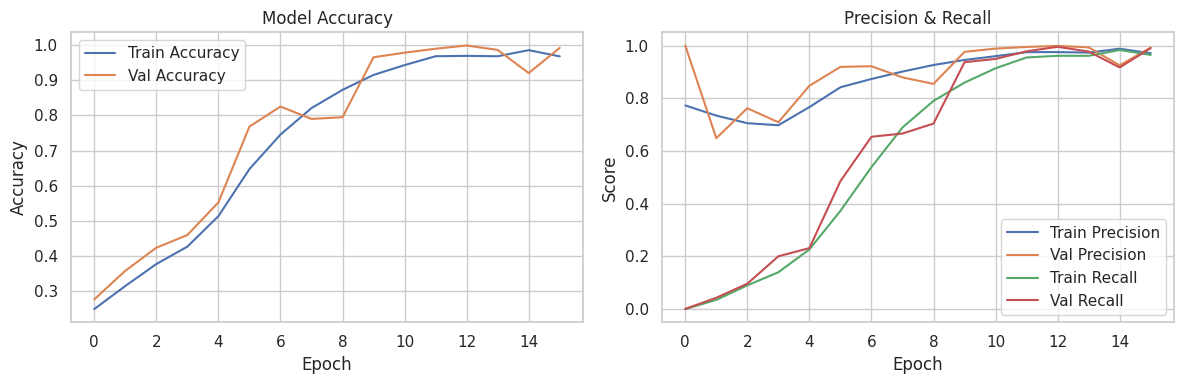

In [88]:
# Training Progress Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision & Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# Model Evaluation
from sklearn.metrics import f1_score
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print("Test Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# F1 Scores
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"\nF1 Scores:")
print(f"Macro: {f1_macro:.4f}")
print(f"Weighted: {f1_weighted:.4f}")

Test Results:
Loss: 0.1234
Accuracy: 0.9972
Precision: 0.9981
Recall: 0.9939

F1 Scores:
Macro: 0.9959
Weighted: 0.9972


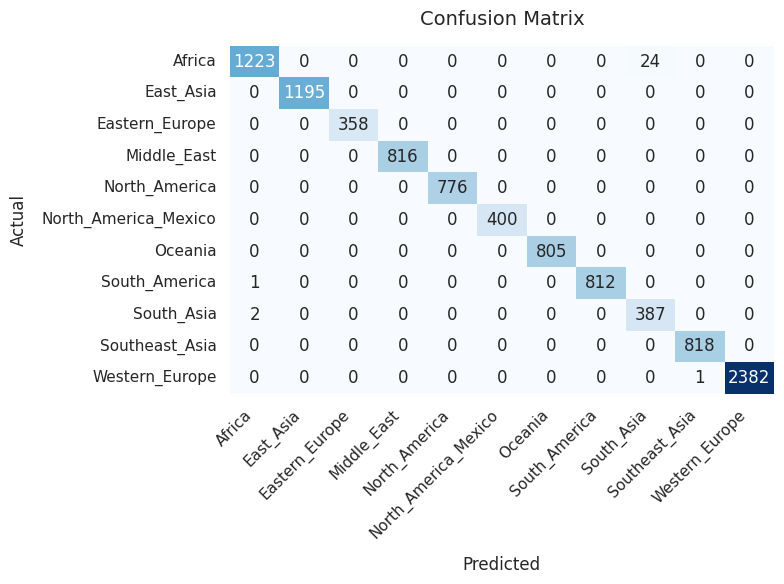

Detailed Classification Report:

                      precision    recall  f1-score   support

              Africa      0.998     0.981     0.989      1247
           East_Asia      1.000     1.000     1.000      1195
      Eastern_Europe      1.000     1.000     1.000       358
         Middle_East      1.000     1.000     1.000       816
       North_America      1.000     1.000     1.000       776
North_America_Mexico      1.000     1.000     1.000       400
             Oceania      1.000     1.000     1.000       805
       South_America      1.000     0.999     0.999       813
          South_Asia      0.942     0.995     0.968       389
      Southeast_Asia      0.999     1.000     0.999       818
      Western_Europe      1.000     1.000     1.000      2383

            accuracy                          0.997     10000
           macro avg      0.994     0.998     0.996     10000
        weighted avg      0.997     0.997     0.997     10000



In [90]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar=False,
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14, pad=15)
plt.xlabel('Predicted', fontsize=12, labelpad=10)
plt.ylabel('Actual', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print Detailed Classification Report below
print("Detailed Classification Report:\n")
print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=label_encoder.classes_, 
    digits=3
))


# Model Explainability

In [112]:
import shap
shap.initjs()

import lime
import lime.lime_tabular

In [113]:
background = shap.sample(X_train, 100, random_state=42)
explainer = shap.Explainer(model, background)
shap_values = explainer(X_test[0:100])


# Absolute Mean SHAP
This plot shows the contribution of each feature globally and ranks them

Classes: ['Africa' 'East_Asia' 'Eastern_Europe' 'Middle_East' 'North_America'
 'North_America_Mexico' 'Oceania' 'South_America' 'South_Asia'
 'Southeast_Asia' 'Western_Europe']


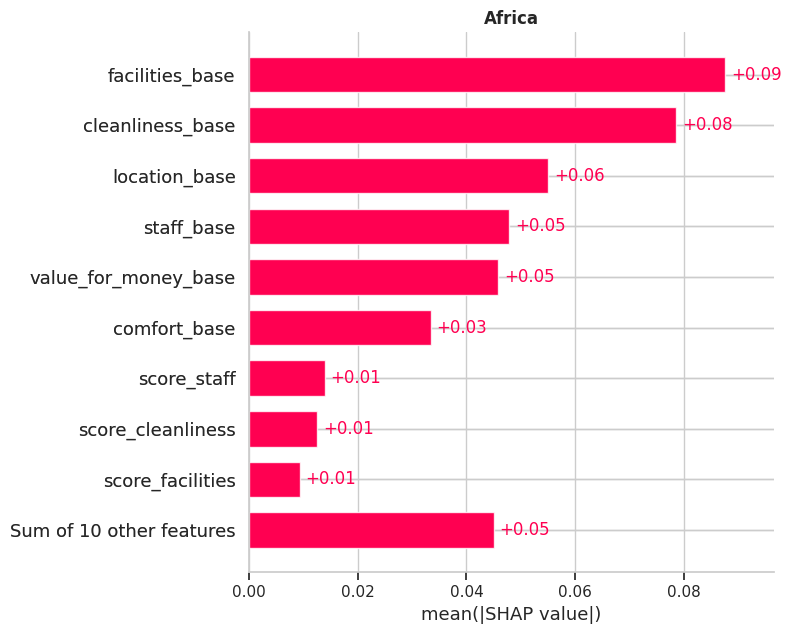

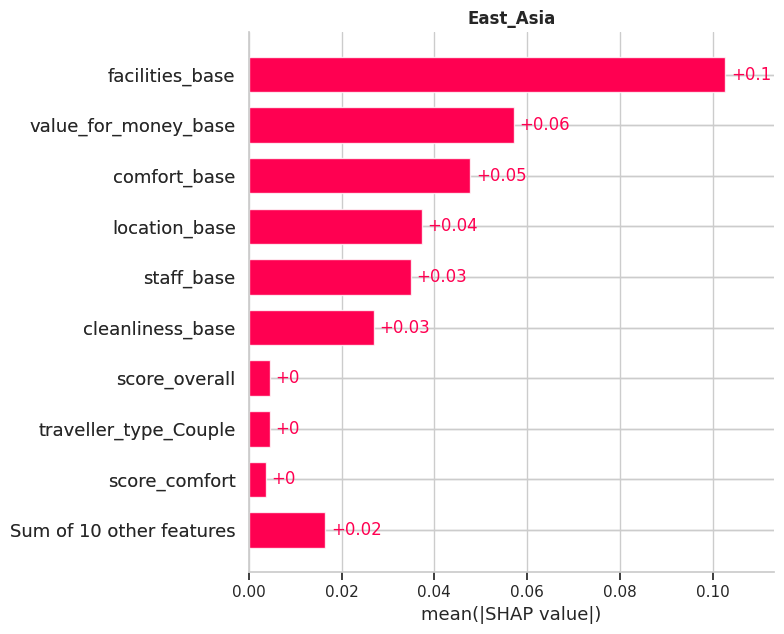

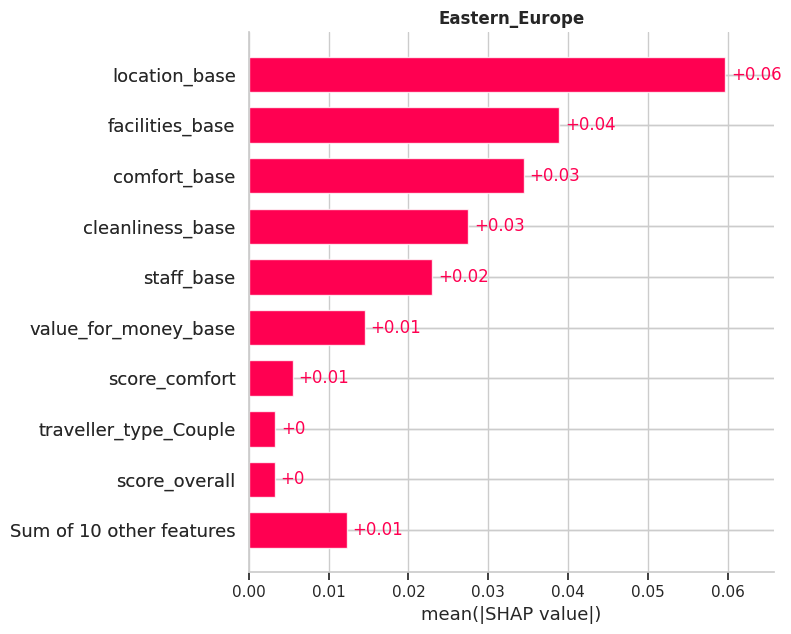

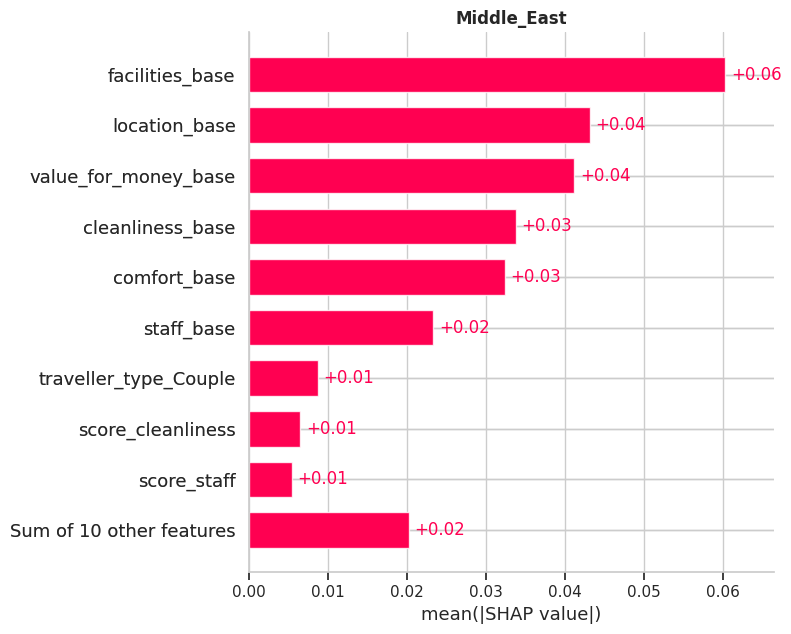

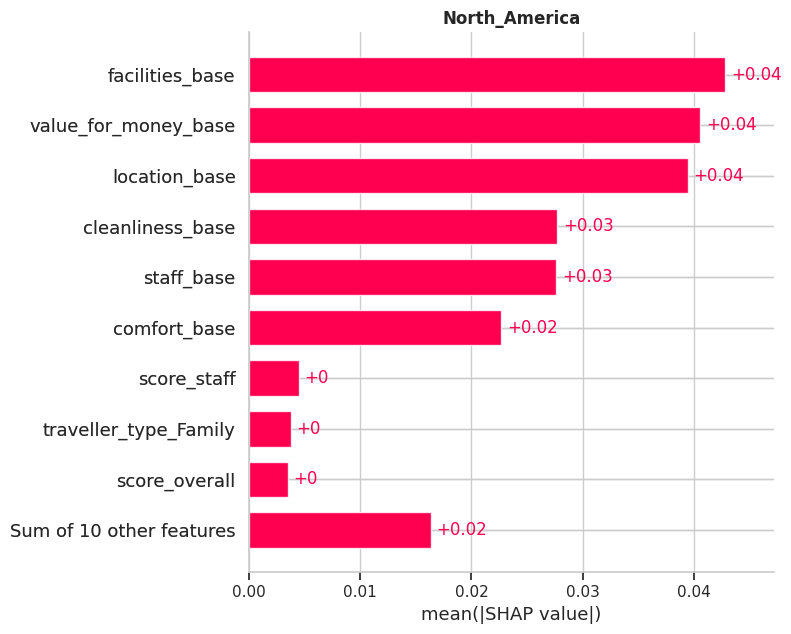

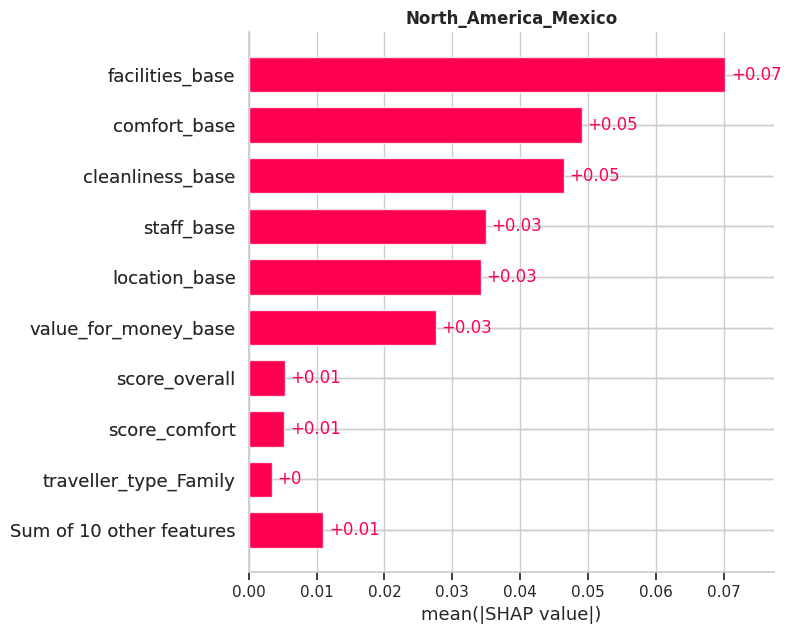

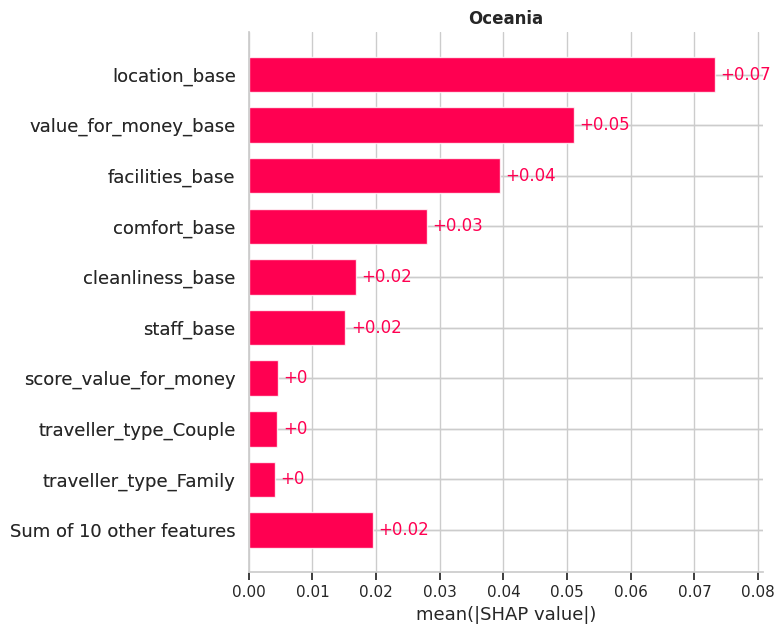

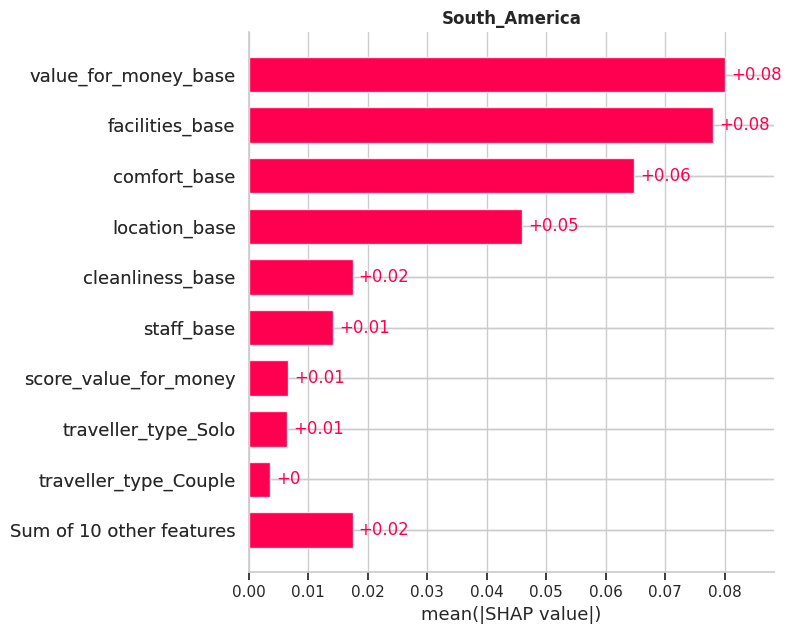

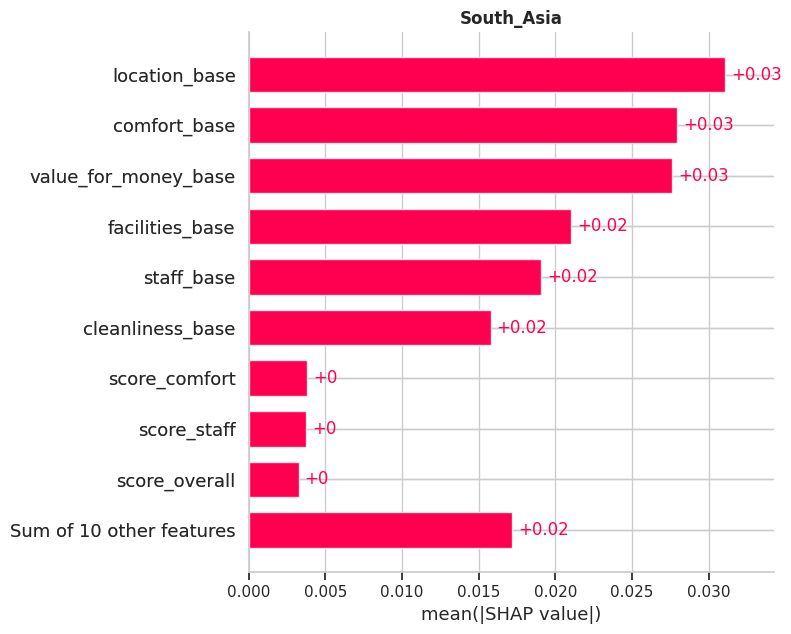

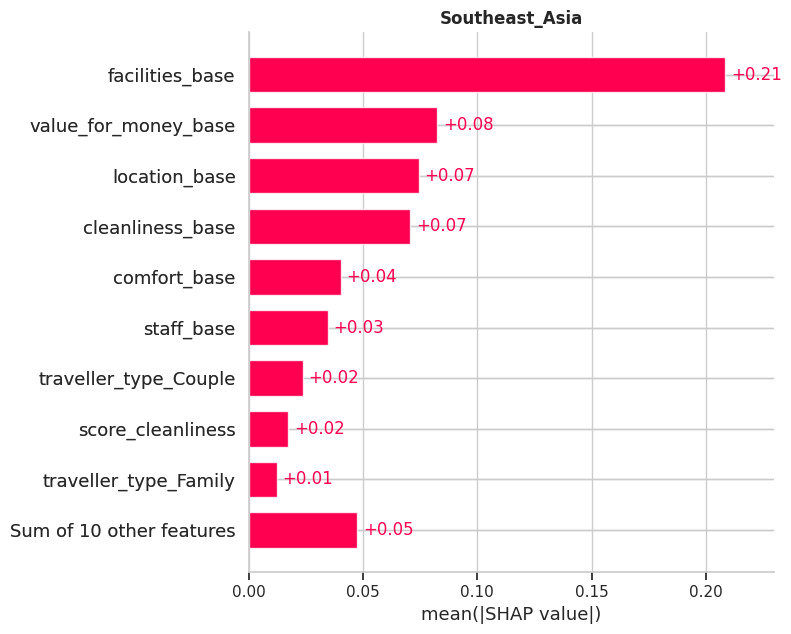

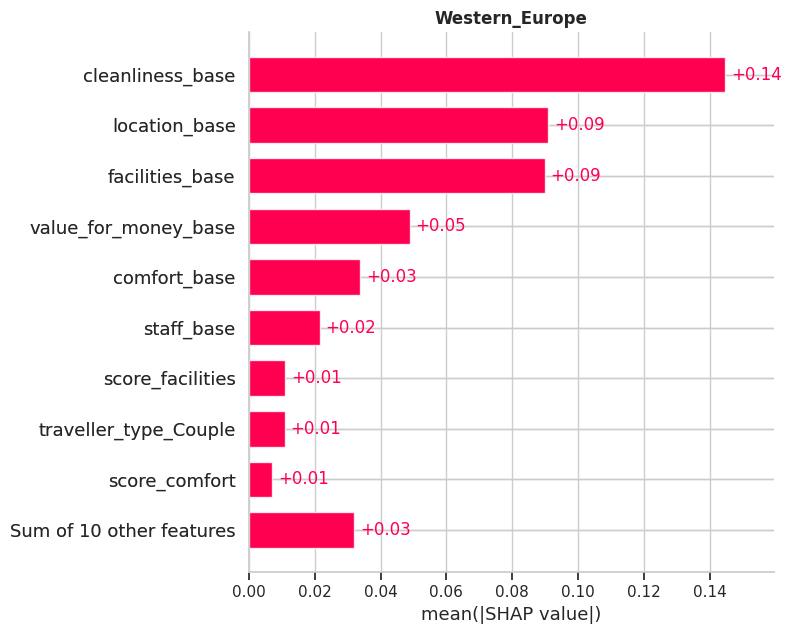

In [114]:
class_names = label_encoder.classes_
print("Classes:", class_names)

for class_idx in range(11):
    # Extract SHAP values for this specific class
    shap_values_class = shap_values[:, :, class_idx]
    
    # Create bar plot for this class
    fig, ax = plt.subplots(figsize=(16, 6))  # new figure and axis
    shap.plots.bar(shap_values_class, show=False)
    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Waterfall Plot
This plot shows the contribution of each feature, moving it from the baseline value, to the prediction value

# Force Plot
This is a similar perspective, in a different format
from IPython.display import display

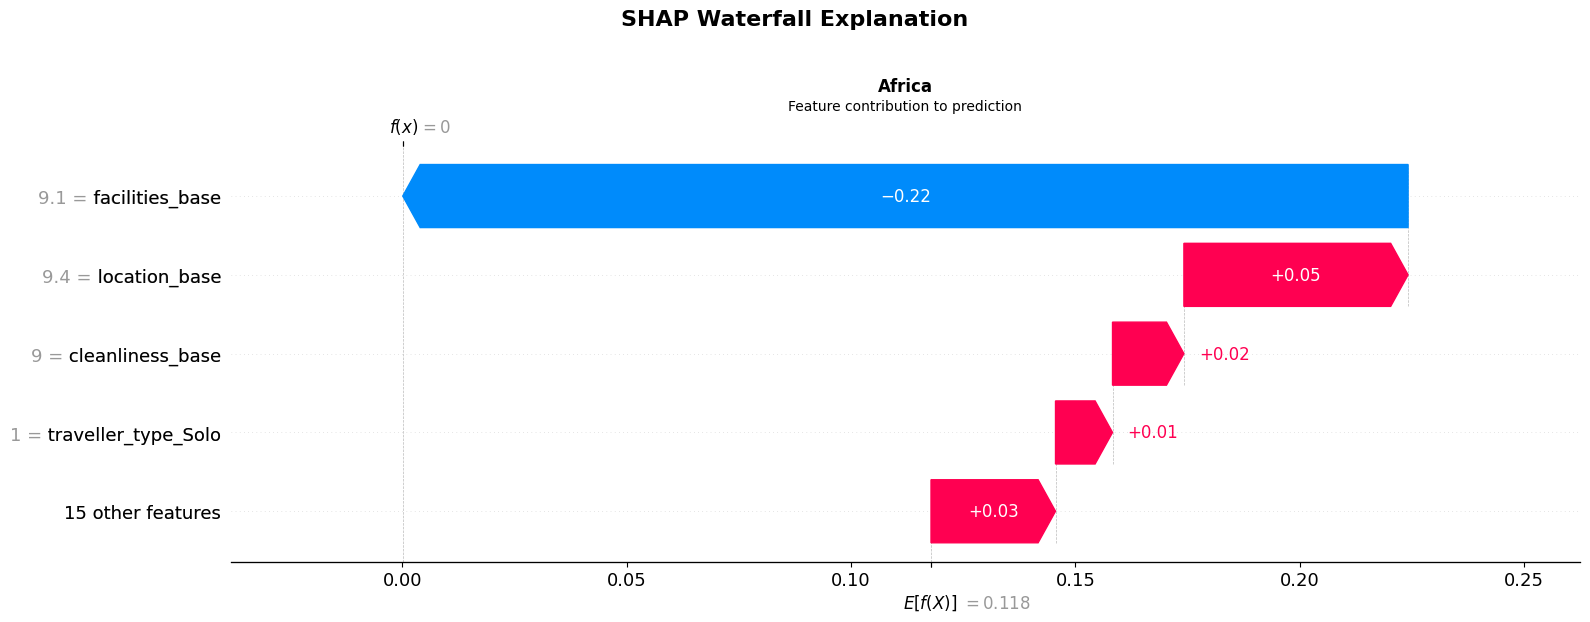

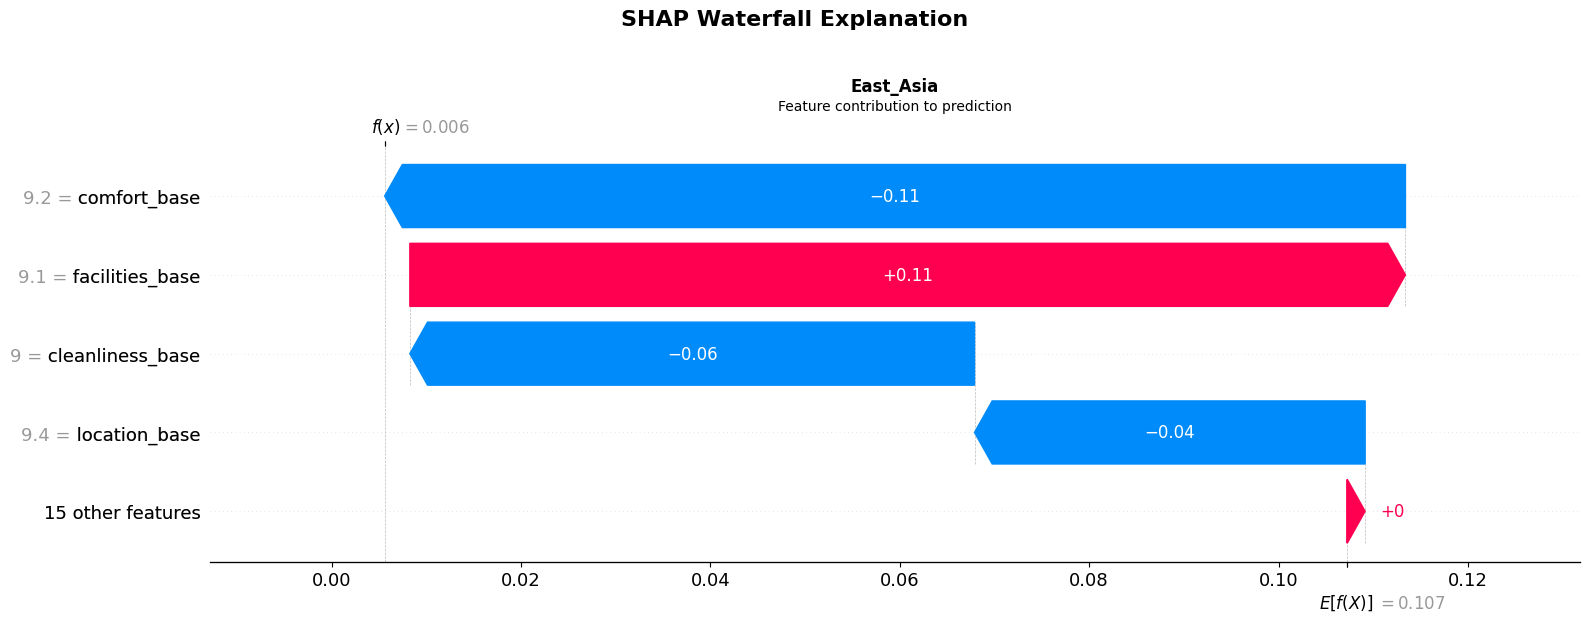

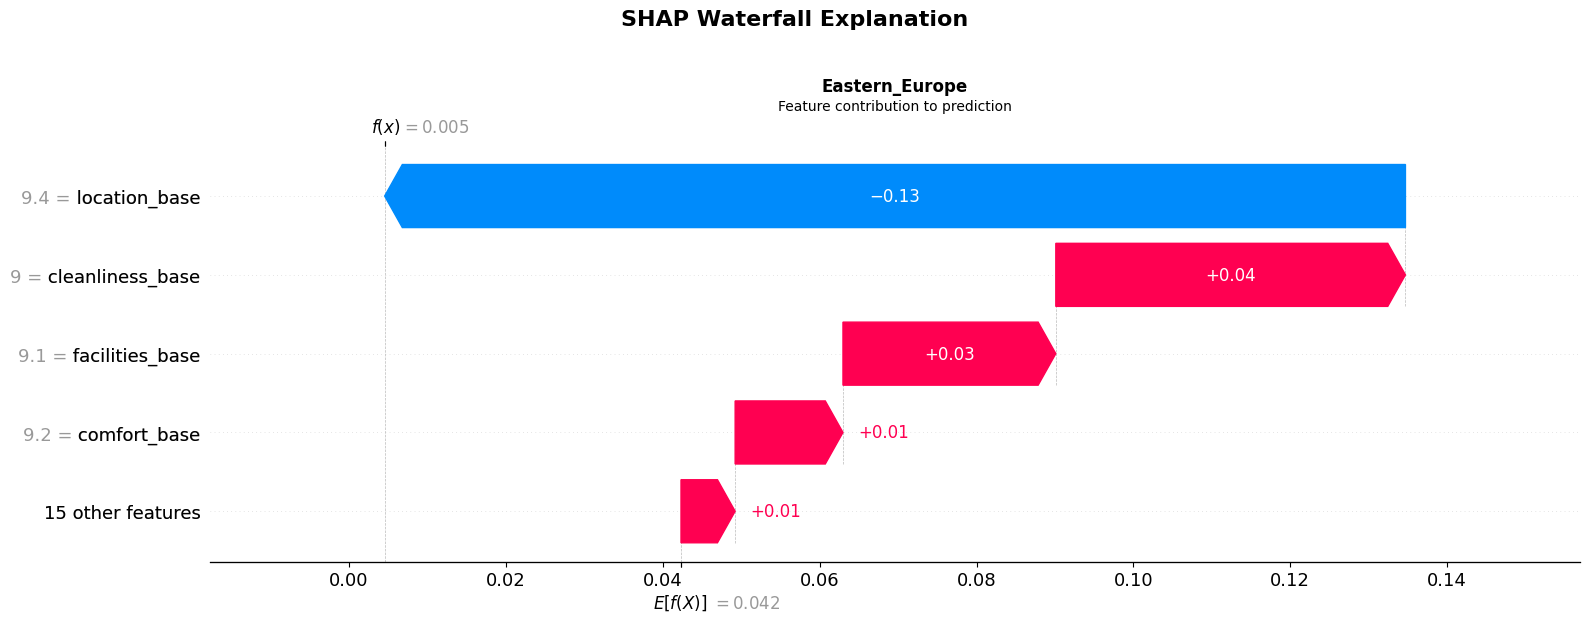

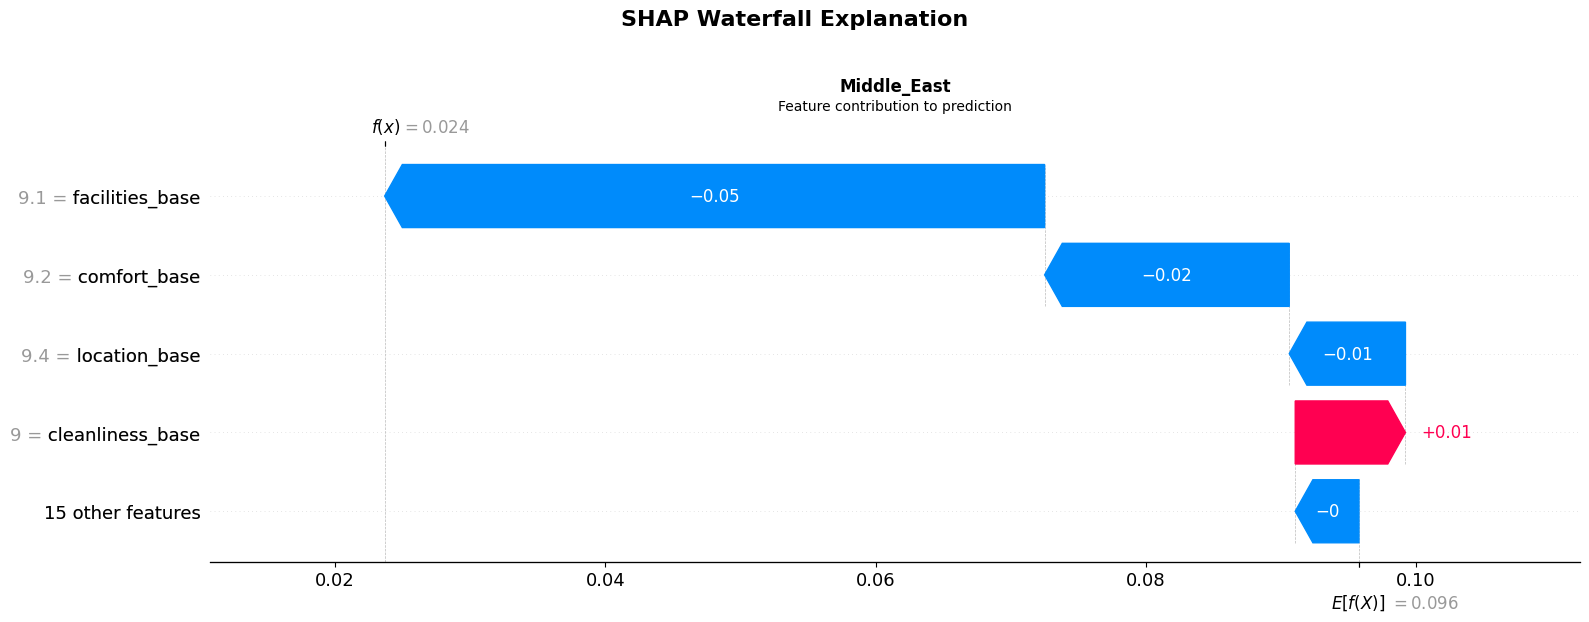

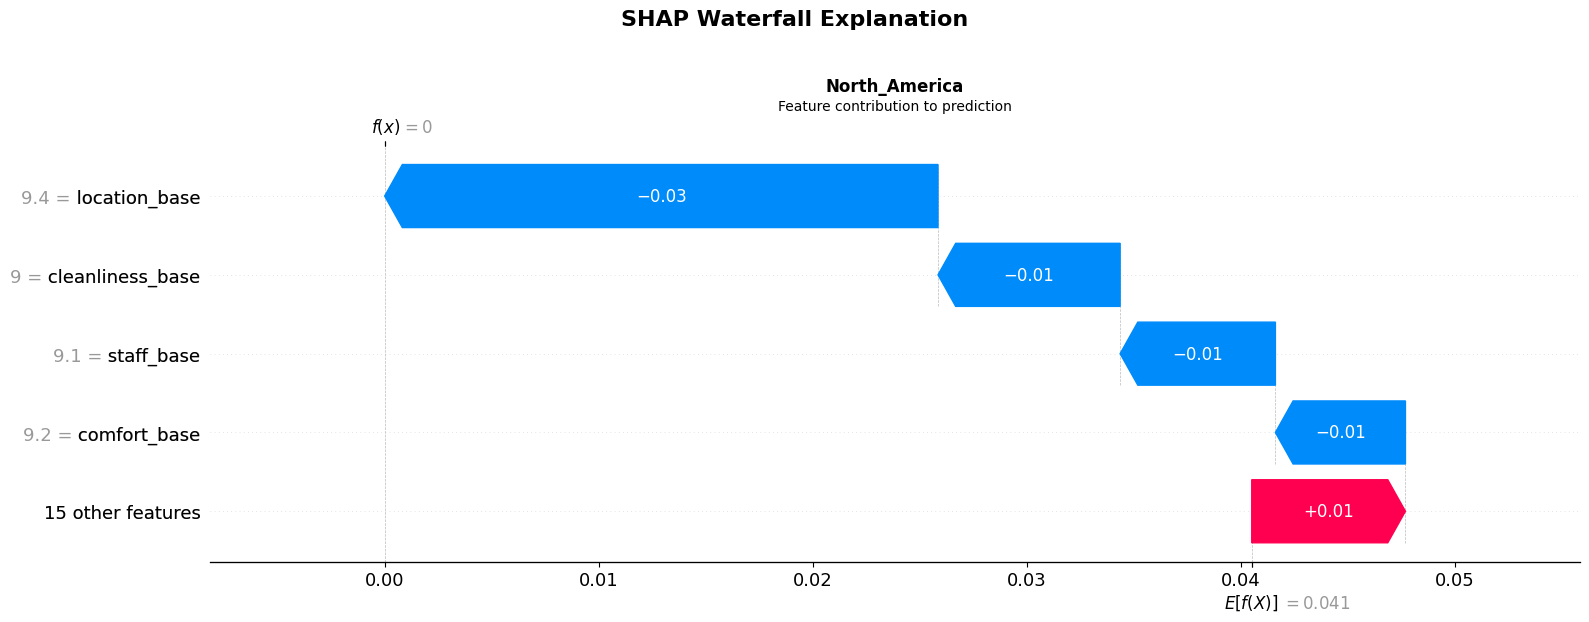

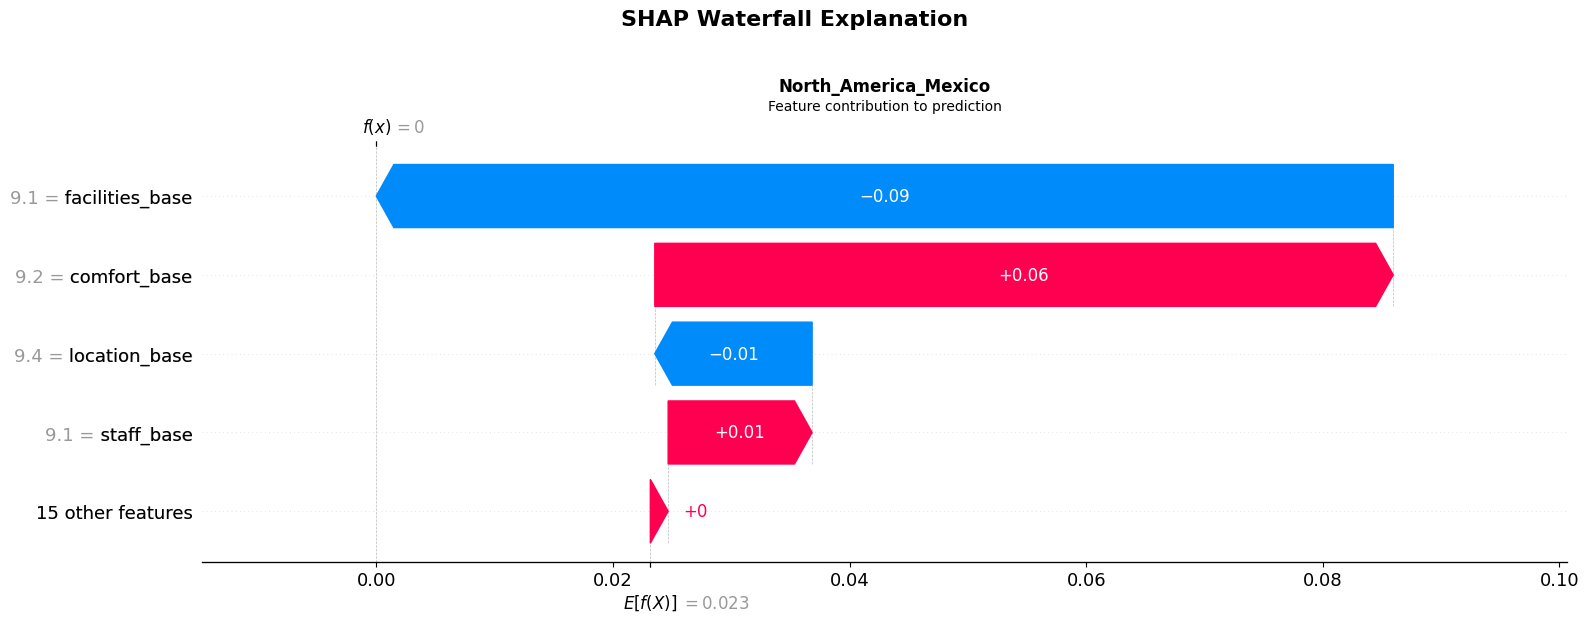

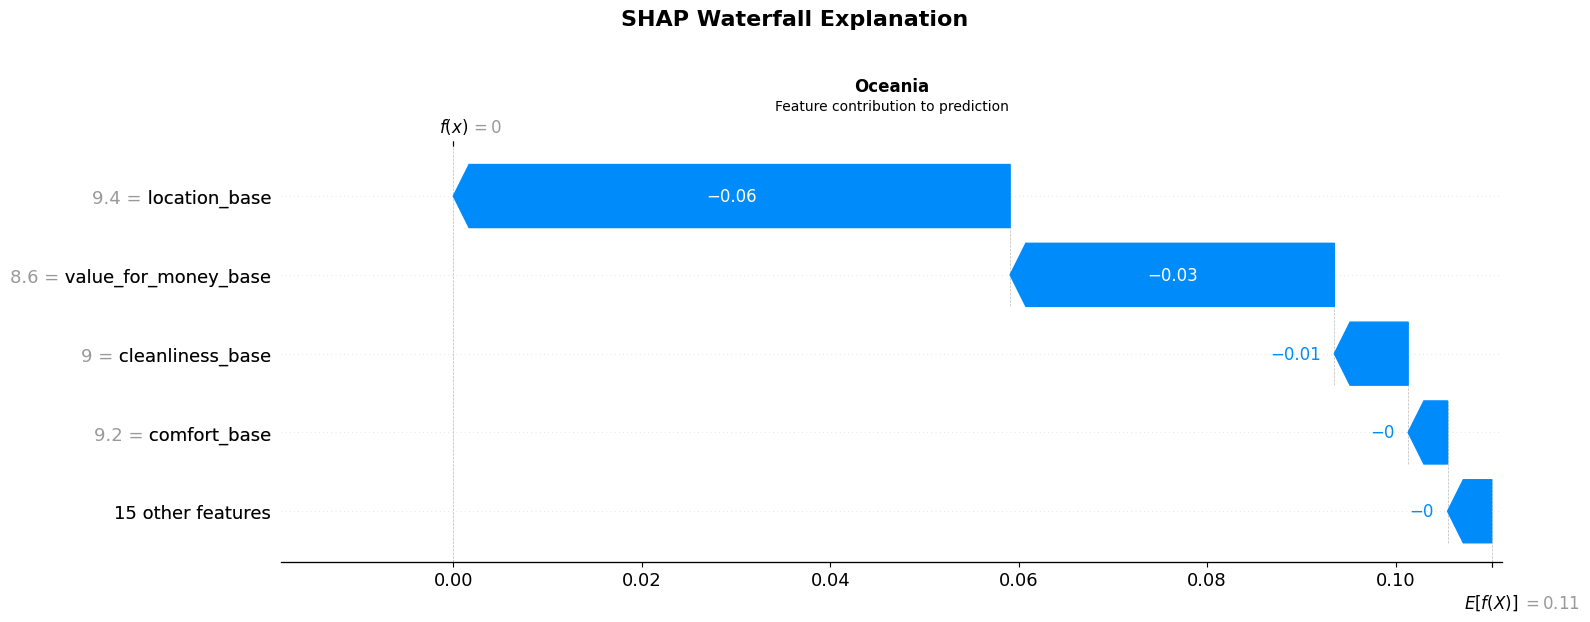

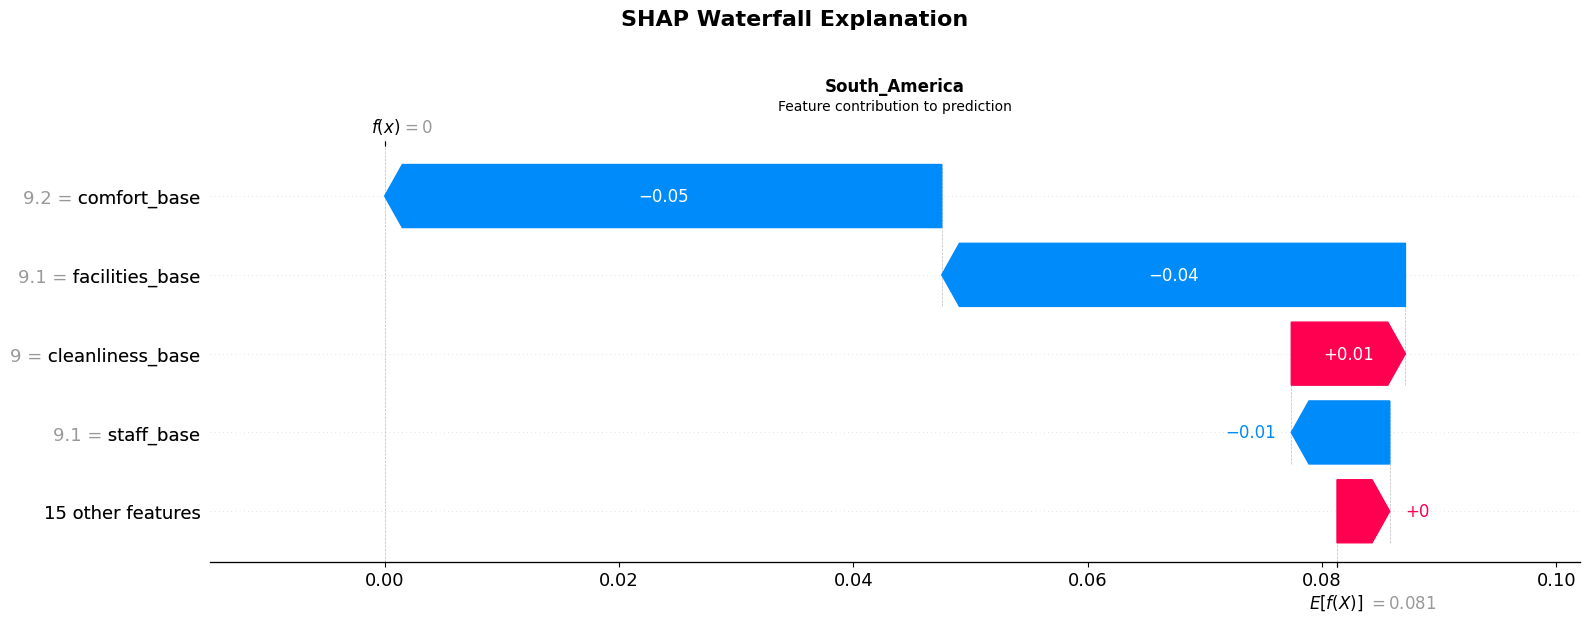

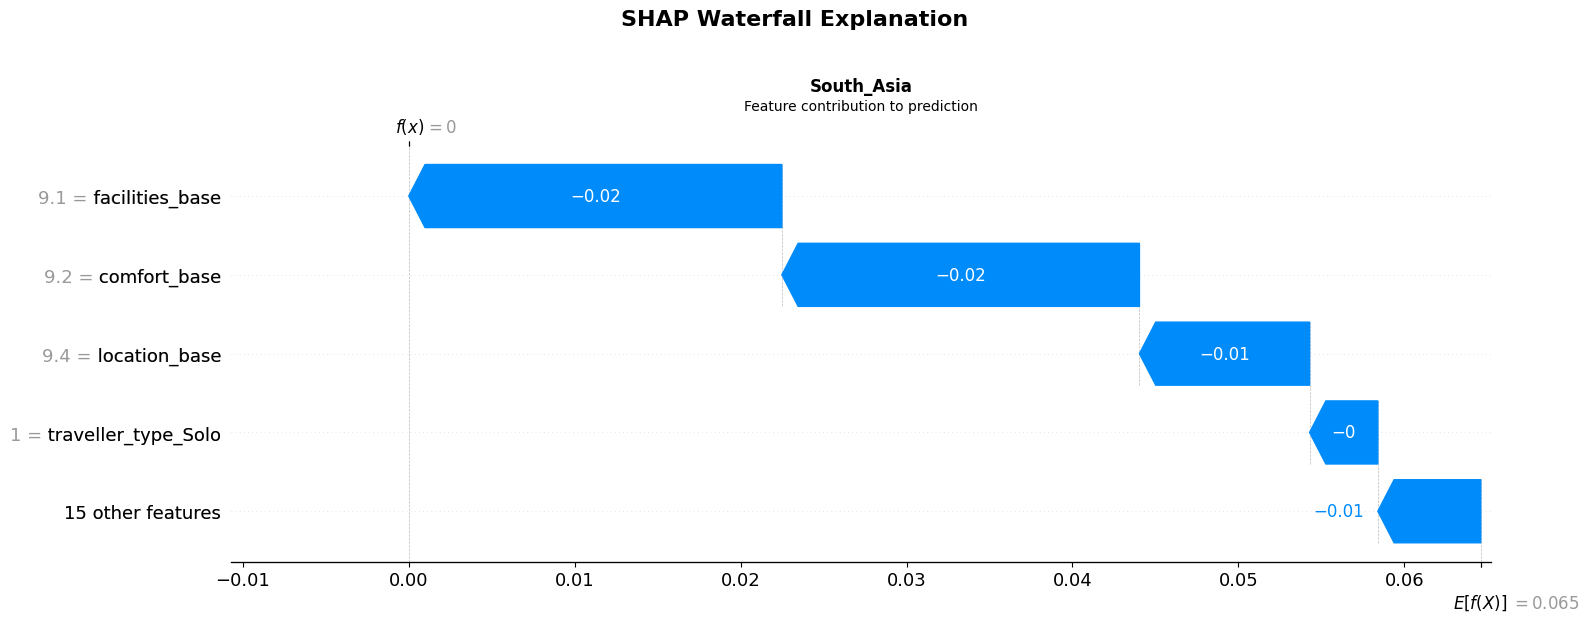

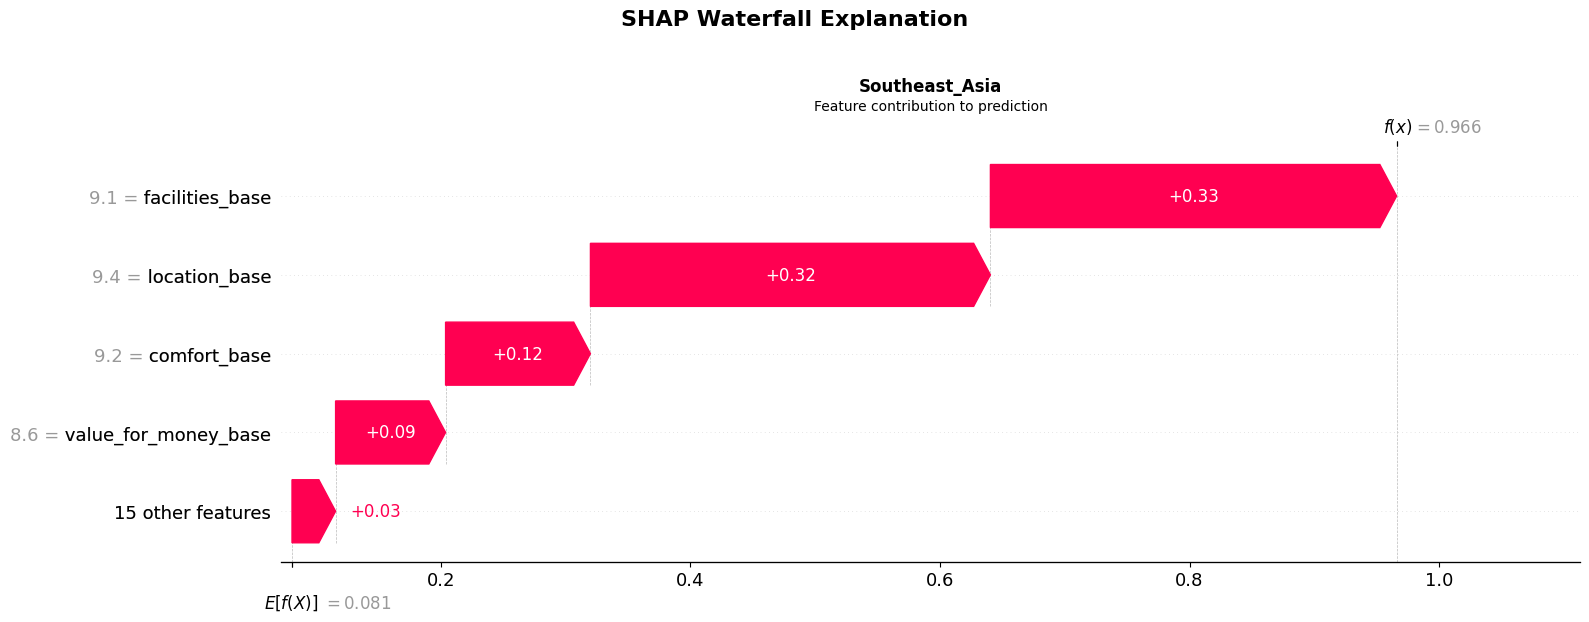

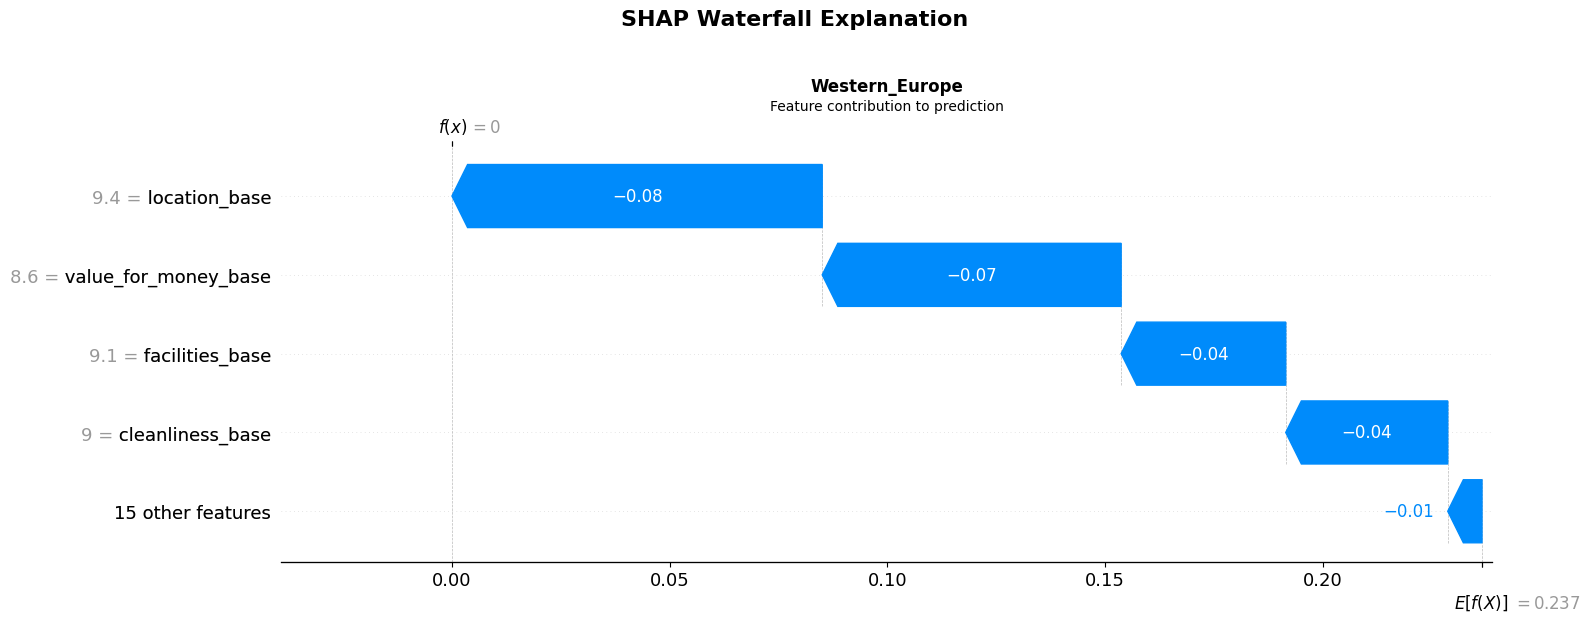

In [48]:
observation = 0

# plt.rcParams['figure.figsize'] = (12, 6)  # default width/height for new figures


for class_idx in range(11):
    # Extract SHAP values for this specific class and observation
    shap_values_class_observation = shap_values[observation, :, class_idx]

    shap.plots.waterfall(shap_values_class_observation, max_display=5, show=False)

    fig = plt.gcf()   # get the current figure
    ax = plt.gca()    # get the current axes

    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel("Feature contribution to prediction")
    fig.suptitle("SHAP Waterfall Explanation", fontsize=16, fontweight="bold", y=1.03)
    plt.gcf().set_size_inches(16, 6)

    plt.tight_layout()
    plt.show()

    display(shap.plots.force(shap_values_class_observation))
